 <center> <h1> <b> Speech Systems (EE6307) </b> </h1> </center>

<b> Programming Assignment - 02 - Analysis and Synthesis of Vowels </b>

Welcome to the second programming assignment in speech systems (EE6307) course. The objective of this assignment is to analyze and synthesize vowels. Current programming assignment is broadly classified into three parts. In the first part of this programming assignment, you need to code an algorithm to analyze the time domain characteristics of the sustained vowels \a\,\i\, and \u\. In the second part of the assignment, We expect you to analyze the frequency domain characteristics of the vowels. In the third part of the assignment, You need to extract the vocal tract and excitation information from the vowels and analyze them in the frequency domain, i.e., visualizing the linear prediction spectrum, finding the formant frequencies, etc. The third part of the assignment also comprises synthesizing the vowels using the estimated vocal tract parameters and different excitations. We feel that listening to the synthesized wave files with different excitation helps us understand the role of various parts of the articulatory system in speech production.  

<b> Instructions </b>
1. Plagiarism is strictly prohibited.
2. Delayed submissions will be penalized with a scaling factor of 0.5 per day.
3. Please DO NOT use any machine learning libraries unless and otherwise specified.






<h4> <b> Part1 (Observe the time domain characteristics of the vowels) : </b>  In part1 of the programming assignment, you need to code an algorithm to analyze the time domain characteristics of the vowels /a/,/i/, and /u/.  </h4>
<br>
<dt> <h4> 1. Record sustained vowels </h4> </dt> 
<dd> <h4>  - /a/ - hot, /i/ - heat, /u/ - hoot  </h4> </dd>
<dd> <h4>  - Record three speech signals "hot.wav", "heat.wav", "hoot.wav"     </h4> </dd>
<dt> <h4> 2. Plot the sustained vowel positioned between the two consonants </h4> </dt> 
<dd> <h4> - Read the speech signal   </h4> </dd>
<dd> <h4> - Obtain the sustained vowel using the voice activity detector implemented in programming assignment-01. </h4> </dd>
<dd> <h4> - Plot the sustained vowel region with the appropriate font size and aspect ratio.    </h4> </dd>
<dd> <h4> - Write down all your analysis in detail. </h4> </dd>



There is no file in the current directory, please record your voice
Recording started!


<IPython.core.display.Javascript object>

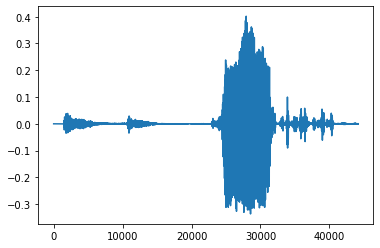

In [ ]:
# Recorder

from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os

#### Please comment below line, if you already uploaded the 'recording.wav' in '/content/'
!rm recording.wav

if os.path.isfile('recording.wav'):
    print("wavefile exists, later part of the code uses 'recording.wav' as input speech")
    (rate,sig) = scipy.io.wavfile.read("recording.wav")
    print(len(sig))
else:
    print("There is no file in the current directory, please record your voice")
    print("Recording started!")
    wav = record(3.0) #It will record three seconds of your speech
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording.wav', 16000, fp_arr)
    plt.plot(fp_arr)
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


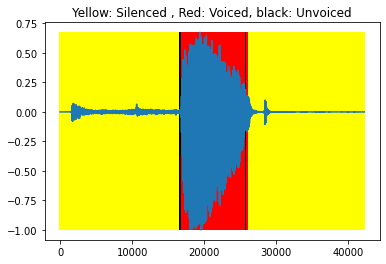

In [ ]:
# Programming assignment functions
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile


def FrameSig(input, rate, frameSize=0.025,frameShift=0.010, window='rectangular'):
    # Takes signal as input and returns a sequence of windowed signals
    '''
    Example :- samplingRate =16000, frameSize= 0.025 sec, frameShift = 0.010 sec
    Input  = (1,16000*5) # The size of the 5 second speech signal with 16 kHz sampling rate 
    Output = (500,400) # Here 500 is the number of frames and 400 is the number of samples in the frame
    '''
    input  = np.array(input).reshape(1, -1)
    input_length = input.shape[1]
    output = []
    frameLength = int(frameSize * rate)
    shiftLength = int(frameShift * rate)
    i = 0
    while i*shiftLength+frameLength < input_length:
      frame = input[0, i*shiftLength:i*shiftLength+frameLength]
      # applying hamming window
      if window=='hamming':
        frame = np.hamming(frameLength).tolist() * frame
      output.append(frame)
      i += 1    
    output = np.array(output)
    return output

def AutoCorrelation(frame):
    # Takes frame as input and returns auto correlation sequence of the frame
    '''
    Input = (1,samplingRate*frameDuration)
    Output = (samplingRate*frameDuration) # auto correlation sequence is symmetric
    '''
    ##################################### 

    myArray = np.array(frame)
    result = np.correlate(myArray, myArray, mode = 'full')
    result = result[result.size // 2 :]
    result = result/result[0]
    return result

def get_f0(Rxx,samplingFreq):
    # Extracts the fundamental frequency from the autocorrelation sequence
    # Location of the second peak in the autocorrelation sequence gives the pitch period
    ##################################### 
    # Complete the code

    index = 1
    peaks = []
    while(index<len(Rxx)-1):
      if(Rxx[index] > Rxx[index - 1] and Rxx[index] > Rxx[index + 1]):
        peaks.append((Rxx[index], index))
      index += 1
    if(len(peaks) == 0):
      sampVal, secondPeakIndex = (Rxx[-1], -1)
    else:
      sampVal, secondPeakIndex = max(peaks, key=lambda item:item[0])

    fundamentalFreq = samplingFreq/(secondPeakIndex)
    if 60 < fundamentalFreq < 200:
      return fundamentalFreq, secondPeakIndex
    else:
      return 0, secondPeakIndex

def Energy(frame):
    #Returns the energy of the signal
    energy = 0
    for i in range(len(frame)):
      energy += np.abs(frame[i])**2

    return energy

def voicedVsUnvoicedvsSilence(frames, sampRate, energyThreshold = 0.8, autoCorrThreshold = 0.6):
  freq = []
  decisions = []
  energies = []
  for i in range(len(frames)):
    Rxx = AutoCorrelation(frames[i])
    f0, secondPeak = get_f0(Rxx, sampRate)
    energies.append(Energy(frames[i]))
    if Energy(frames[i]) > energyThreshold:
      if Rxx[secondPeak] > autoCorrThreshold:
        decisions.append({"decision" : "voiced", "pitch" : f0})
      else:
        decisions.append({"decision" : "unvoiced", "pitch" : 0})
    else:
      decisions.append({"decision" : "silenced", "pitch" : 0})

  return decisions, energies

(rate, recording_a) = scipy.io.wavfile.read('/content/drive/My Drive/hot.wav')
recording_a = recording_a/max(abs(recording_a))

frameSize = 0.025
frameShift = 0.010

frames = FrameSig(input = recording_a, rate = rate)
decisions, energies  = voicedVsUnvoicedvsSilence(frames, rate)

for i in range(len(decisions)):
  size = int(frameSize * rate)
  shift = int(frameShift * rate)

  array = np.arange(i*shift, i*shift + size, dtype='int')
  
  if decisions[i]["decision"] == "voiced":
    plt.vlines(x=array, ymin=min(recording_a), ymax=max(recording_a), colors='red', lw=2)
  elif decisions[i]["decision"] == "unvoiced":
    plt.vlines(x=array, ymin=min(recording_a), ymax=max(recording_a), colors='black', lw=2)
  elif decisions[i]["decision"] == "silenced":
    plt.vlines(x=array, ymin=min(recording_a), ymax=max(recording_a), colors='yellow', lw=2)

plt.plot(recording_a)
plt.title("Yellow: Silenced , Red: Voiced, black: Unvoiced")
plt.show()

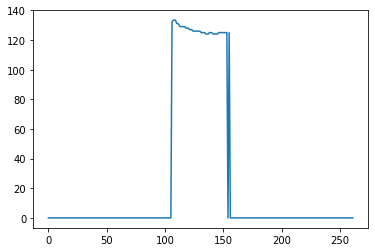

In [ ]:
pitchContour = []
indexes = []
for i in range(len(decisions)):
  # if decisions[i]["pitch"] != 0:
  pitchContour.append(decisions[i]["pitch"])
  indexes.append(i)
plt.plot(indexes, pitchContour)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


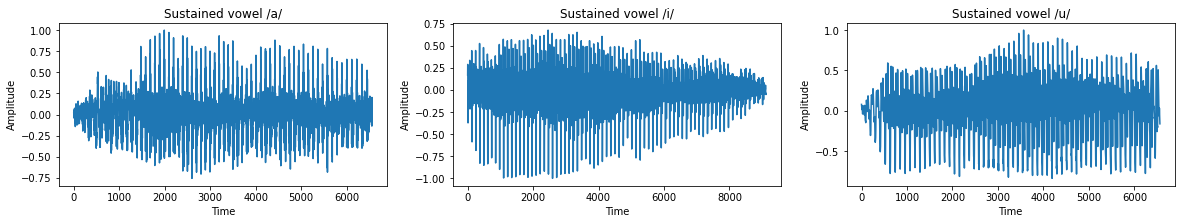

In [ ]:
def VoiceRegios(sig_input,sig_rate):
  #Takes input as speech signals and ouputs the flag indicating whether the frames of the speech signal are voiced or not
  frames = FrameSig(input = sig_input, rate = sig_rate)
  decisions = voicedVsUnvoicedvsSilence(frames, sig_rate)[0]
  return decisions

def Extract1D(sig_input,voiced_flag, shift):
  #Given an input speech signal and voicing flags at frame level, it returns the 1D signal where voicing is there
  voicedRegs = []
  flag = 0
  first = 0
  last = 0
  for i in range(len(voiced_flag)):
    if voiced_flag[i]["decision"] == "voiced" and flag == 0:
      first = i
      flag = 1
    elif voiced_flag[i]["decision"] == "voiced" and flag == 1:
      last = i

    # if voiced_flag[i]["decision"] == "voiced":
    #   voicedRegs.extend(sig_input[i*shift:i*shift + shift])
  
  # return voicedRegs
  return sig_input[first*shift:last*shift]

# #Load the recorded speech signal
(rate, recording_a) = scipy.io.wavfile.read('/content/drive/My Drive/hot.wav')
(rate, recording_i) = scipy.io.wavfile.read('/content/drive/My Drive/heat.wav')
(rate, recording_u) = scipy.io.wavfile.read('/content/drive/My Drive/hoot.wav')

# #Run your voice activity detector build in programming assignment1 to detect voiced frames
recording_a = recording_a/max(abs(recording_a))
recording_i = recording_i/max(abs(recording_i))
recording_u = recording_u/max(abs(recording_u))

voiced_a = VoiceRegios(recording_a,rate)
voiced_i = VoiceRegios(recording_i,rate)
voiced_u = VoiceRegios(recording_u,rate)

# #Extract 1 dimensional signal using voiced tags of the frames
sustained_a = Extract1D(recording_a,voiced_a, int(frameShift*rate))
sustained_i = Extract1D(recording_i,voiced_i, int(frameShift*rate))
sustained_u = Extract1D(recording_u,voiced_u, int(frameShift*rate))


# #Plot the sustained vowels /a/,/i/ and /u/ with appropriate font and aspect ratio
plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.plot(sustained_i)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Sustained vowel /a/")
plt.subplot(1,3,2)
plt.plot(sustained_a)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Sustained vowel /i/")
plt.subplot(1,3,3)
plt.plot(sustained_u)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Sustained vowel /u/")

sustained = {"a" : sustained_a, "i" : sustained_i, "u" : sustained_u}

<h4> <b> Part1 Report : </b>  Write down your observations from the time domain plots of the vowels /a/,/i/ and /u/. </h4>

* **'/a/'** :- This vowel exists from t = 1.06s to t = 1.63s of its wav file and has been successfully extracted as voiced region using voice activity detector
* **'/i/'** :- This vowel exists from t = 1.15s to t = 1.56s of its wav file and has been successfully extracted as voiced region using voice activity detector
* **'/u/'** :- This vowel exists from t = 0.64s to t = 1.05s of its wav file and has been successfully extracted as voiced region using voice activity detector



<h4> <b> Part2 (Observe the frequency domain characteristics of the vowels) : </b>  In part2 of the programming assignment, you need to code an algorithm to analyze the frequency domain characteristics of the vowels /a/,/i/, and /u/.  </h4>
<br>

<dt> <h4> 1. Plot the magnitude spectra for short segment of 25 ms of sustained vowel </h4> </dt> 
<dd> <h4> - Read the speech signals recorded in part 1 of the programming assignment.   </h4> </dd>
<dd> <h4> - Obtain the sustained vowel using the voice activity detector implemented in programming assignment-01. </h4> </dd>
<dd> <h4> - Plot the magnitude spectra of the sustained vowel region </h4> </dd>

<dt> <h4> 2. Frequency domain analysis of the vowels </h4> </dt>
<dd> <h4> - Manually identify the formants of all the three vowels i.e /a/,/i/ and /u/ from the magnitude spectrum   </h4> </dd>
<dd> <h4> - Observe the effect of spectral sampling on male and female speakers   </h4> </dd>
<dd> <h4> - Observe the effect of window size - 32 ms, 16 ms, 8 ms and the exact pitch period  </h4> </dd>
<dd> <h4> - How can you estimate F0 from the magnitude spectrum? </h4> </dd>


<br/>



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


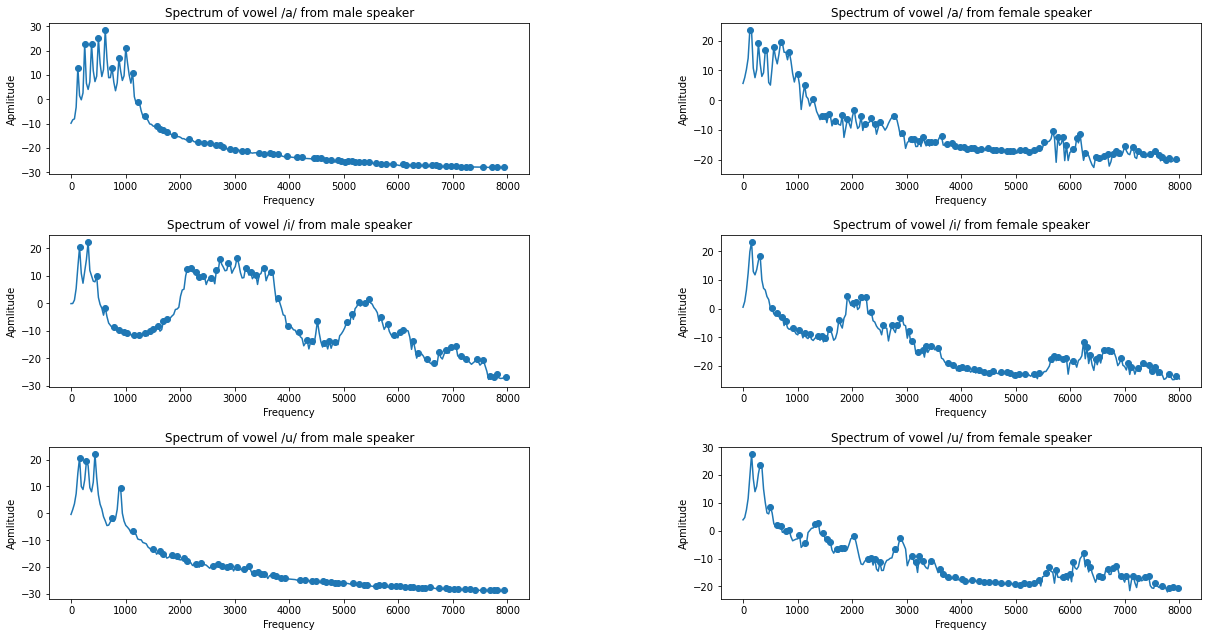

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

def getPeaks(arr, freq):
    index = 1
    peaks = []
    peaksF = []
    while(index<len(arr)-1):
      if(arr[index] > arr[index - 1] and arr[index] > arr[index + 1]):
        peaks.append(arr[index])
        peaksF.append(freq[index])
      index += 1
    return peaks, peaksF

def ComputeMagSpectrum(dict, sampRate, winSize = 0.025):
    #Takes input as speech signal stored in a dictionary and outputs the magnitude spectra stored in a dictionary
    #Complete the code
    magSpecDict = {}
    vowel_list = ["a","i","u"]
    freqDict = {}
    peaks = {}

    for i in range(0,len(vowel_list),1):
      array = []
      frames = FrameSig(input = dict[vowel_list[i]], rate = sampRate, frameSize = winSize)
      freq = []
      for j in range(len(frames)):
        fft_data = np.fft.fft(frames[j], n=512)
        N = int(len(fft_data)/2)
        magnitude = (20*np.log10(np.abs(fft_data[:N]))).tolist()
        array.append(magnitude)
        fre = np.linspace(0,(16000/ 2),N)
        freq = fre.tolist()
      magSpecDict[vowel_list[i]] = np.mean(array, axis = 0)
      freqDict[vowel_list[i]] = freq
      peaks[vowel_list[i]] = getPeaks(magSpecDict[vowel_list[i]], freqDict[vowel_list[i]])

    return magSpecDict, freqDict, peaks

def ExtractVowel(dict, sampRate):
    #Takes input as speech signal stored in a dictionary and extracts the sustained vowel regions and stores them in dictionary
    #Complete the code
    extractedDict = {}
    vowel_list = ["a","i","u"]

    for i in range(0,len(vowel_list),1):
      normRecording = dict[vowel_list[i]]/max(abs(dict[vowel_list[i]]))
      voicedRegs = VoiceRegios(normRecording, sampRate)
      extractedDict[vowel_list[i]] = Extract1D(dict[vowel_list[i]], voicedRegs, int(frameShift*rate))

    return extractedDict


male_recording   =  ["/content/drive/My Drive/hot.wav","/content/drive/My Drive/heat.wav","/content/drive/My Drive/hoot.wav"] #Locations of "hot","heat" and "hoot" signals from the male speaker 
female_recording =  ["/content/drive/My Drive/hotF.wav","/content/drive/My Drive/heatF.wav","/content/drive/My Drive/hootF.wav"] #Locations of "hot","heat" and "hoot" signals from the female speaker 


################################################################################
#Load the speech signals from both male and female speakers
#Initialize two dictionaries for storing the signals of male and female speakers
#The keys of the dictionary indicates the vowel i.e /a/,/i/ and /u/.
################################################################################


vowel_list = ["a","i","u"]
Dict_male_recording={}
Dict_female_recording={}

for i in range(0,len(vowel_list),1):
    (Dict_male_recording[vowel_list[i]], rate) = sf.read(male_recording[i])
    (Dict_female_recording[vowel_list[i]], rate) = sf.read(female_recording[i])

#Obtain sustained vowel regions from the entire speech signal
Dict_male_vowel = ExtractVowel(Dict_male_recording, rate)
Dict_female_vowel = ExtractVowel(Dict_female_recording, rate)

#Compute the magnitude spectrum of the sustained vowels 
Dict_male_spectra, freqM, peaksM = ComputeMagSpectrum(Dict_male_vowel, rate)
Dict_female_spectra, freqF, peaksF = ComputeMagSpectrum(Dict_female_vowel, rate)

plt.figure(figsize=(20,10))
counter=1
for key in Dict_male_spectra.keys():
    #Iterates through the dictionary and 
    plt.subplot(3,2,counter)
    plt.plot(freqM[key], Dict_male_spectra[key])
    plt.scatter(peaksM[key][1], peaksM[key][0])
    plt.xlabel("Frequency")
    plt.ylabel("Apmlitude")
    plt.title("Spectrum of vowel /" + key + "/ from male speaker")
    plt.subplot(3,2,counter+1)
    plt.plot(freqF[key], Dict_female_spectra[key])
    plt.scatter(peaksF[key][1], peaksF[key][0])
    plt.xlabel("Frequency")
    plt.ylabel("Apmlitude")
    plt.title("Spectrum of vowel /" + key + "/ from female speaker")
    counter = counter + 2

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()


<h4> <b>  Observe the effect of window size </b>  </h4>

<dt> <h4> 1. Frame the speech signal with specific window lengths </h4> </dt>
<dt> <h4> 2. Compute the magnitude spectrum of the frames and average it to get the overall spectrum of the correspoding vowel </h4> </dt> 

<dd> <h4> - Analyze the spectrum of vowels with different window sizes and report your obervations   </h4> </dd>
<dd> <h4> - Analyze the spectrum of vowels from both male and female speakers and report your obervations   </h4> </dd>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


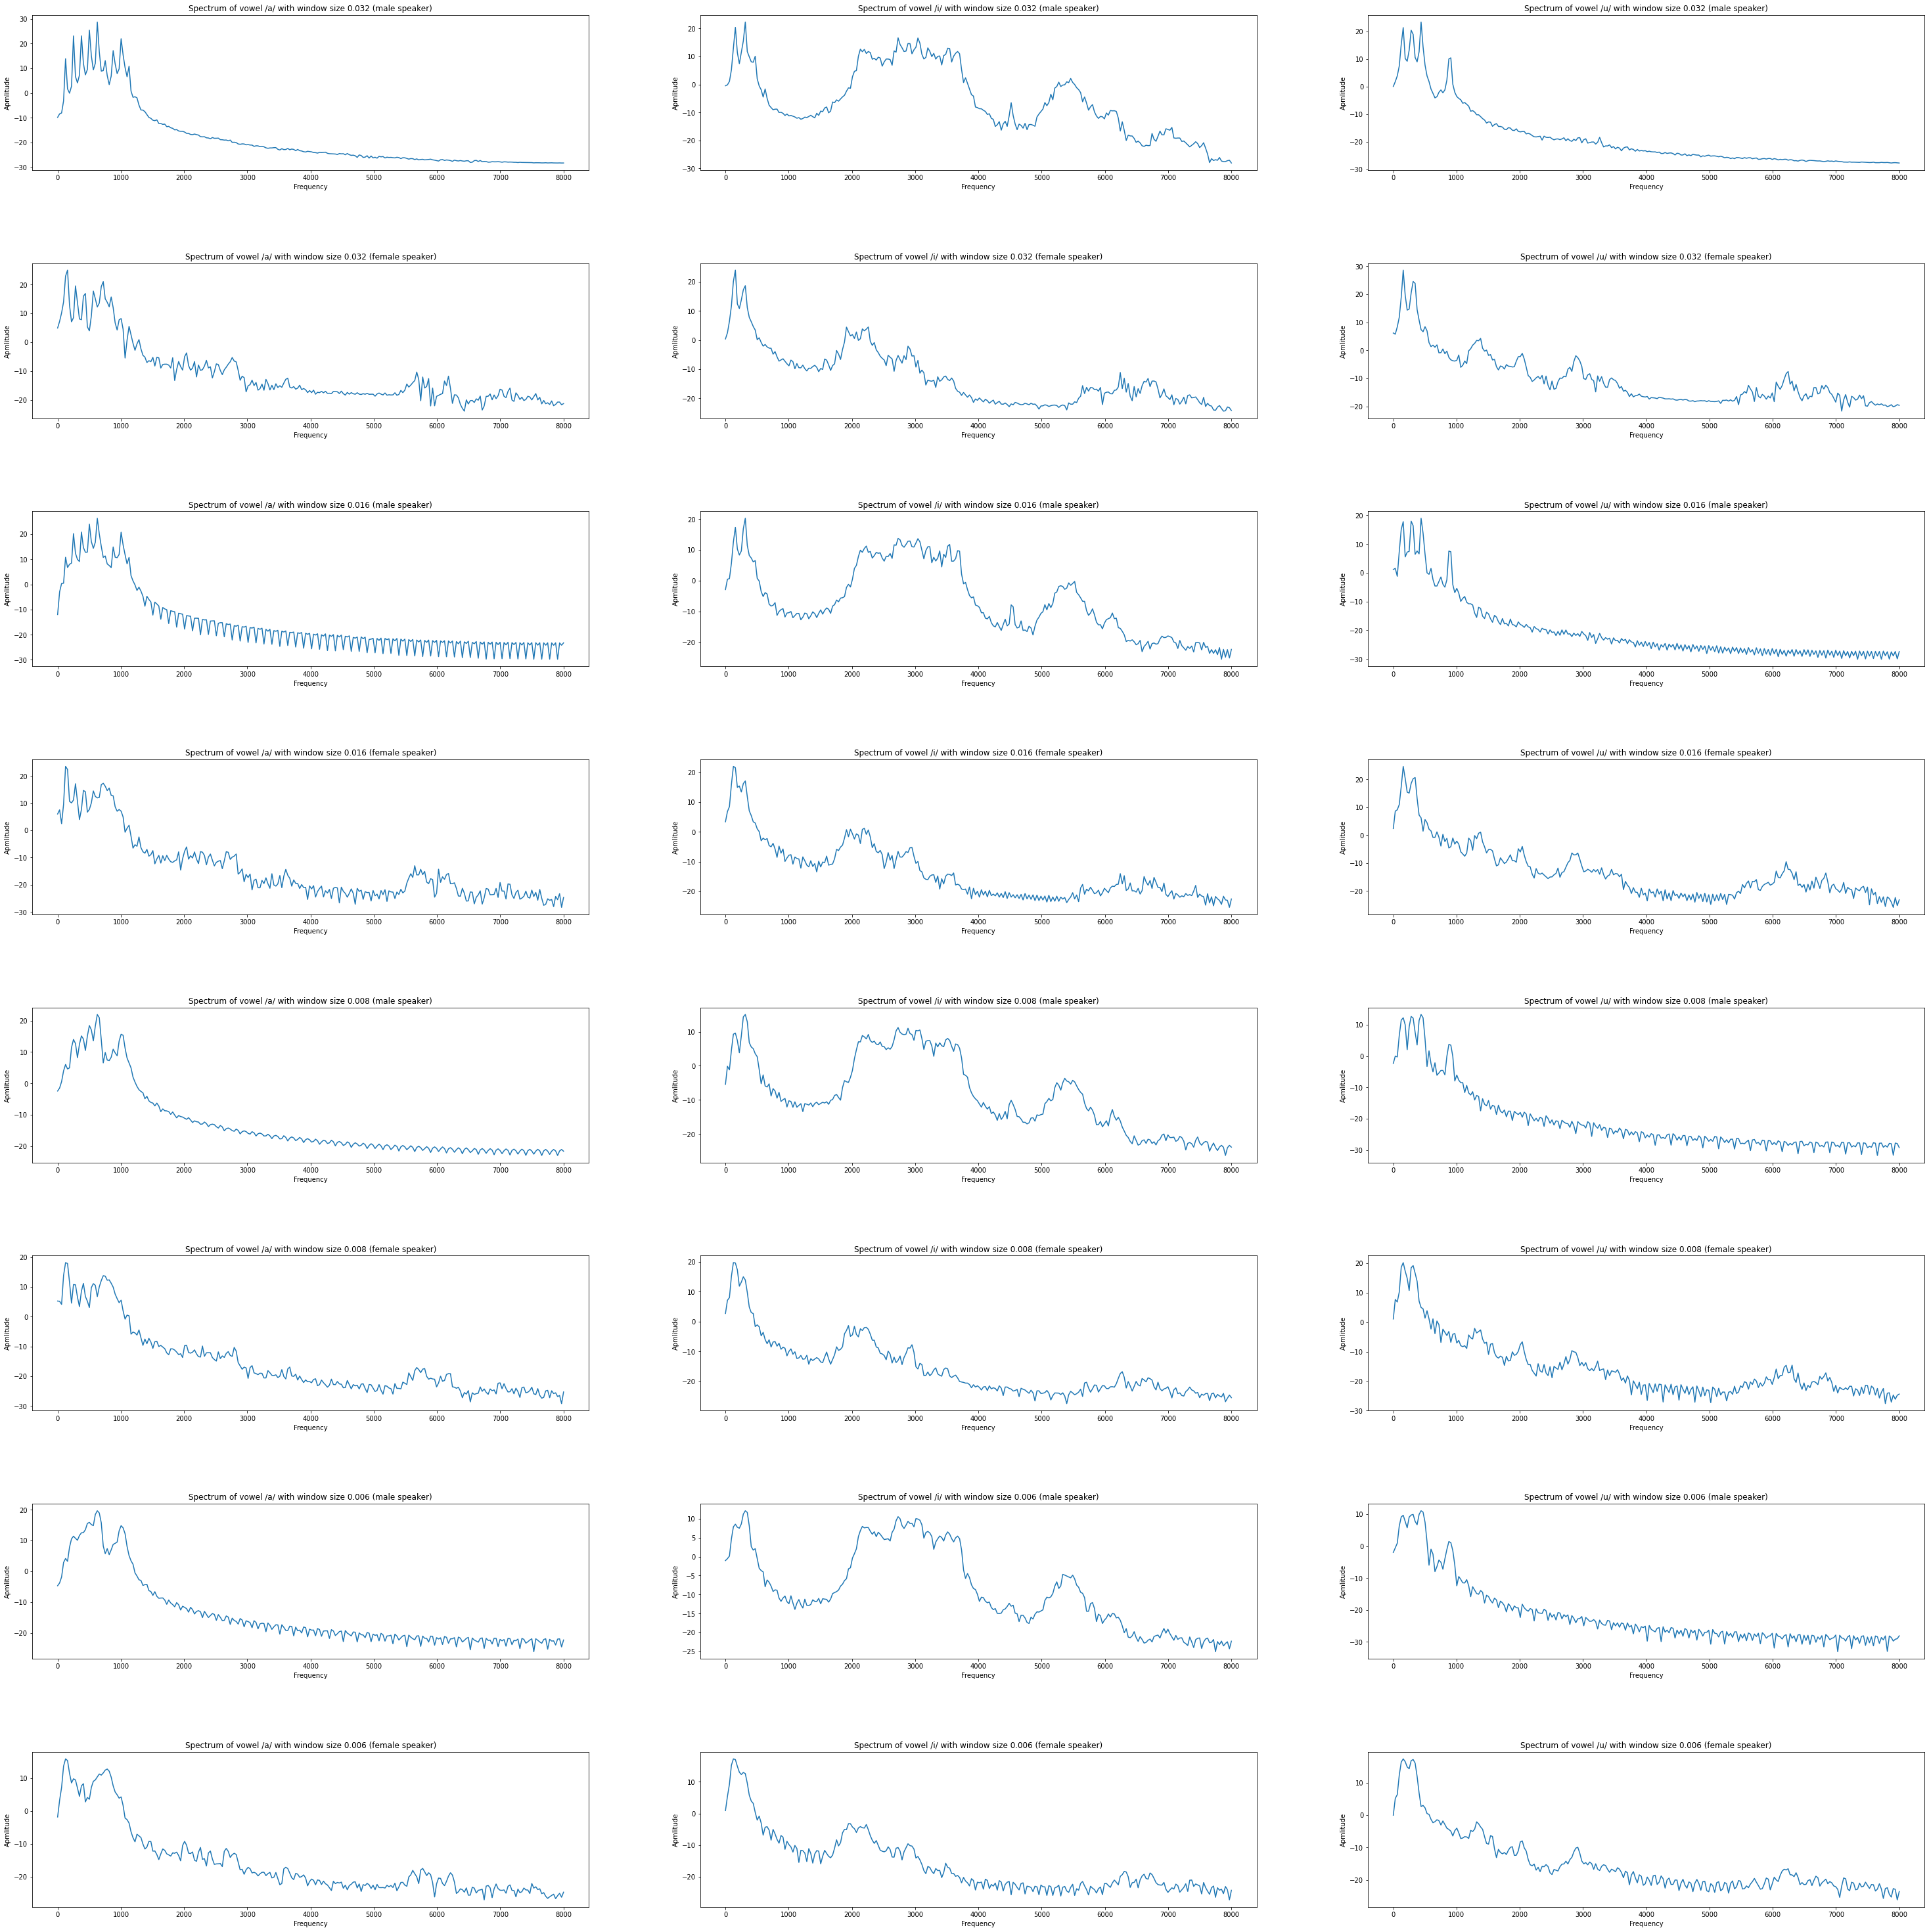

In [ ]:
Exact_pitch = 0.006 #Please fill it based on your voice or recordings used to do the assignment
window_sizes = [0.032,0.016,0.008,Exact_pitch] #Compute the spectra for each frame of the vowel and average it to get the overall spectral of the correspoding vowel
vowel_list = ["a","i","u"]
spectrum = {}

for window_size in window_sizes:
    #Obtain the vowels from both male and female speakers
    Dict_male_recording={}
    Dict_female_recording={}

    for i in range(0,len(vowel_list),1):
        (Dict_male_recording[vowel_list[i]], rate) = sf.read(male_recording[i])
        (Dict_female_recording[vowel_list[i]], rate) = sf.read(female_recording[i])

    Dict_male_vowel = ExtractVowel(Dict_male_recording, rate)
    Dict_female_vowel = ExtractVowel(Dict_female_recording, rate)

    #Frame the signal with window_size
    #Compute the the magnitude spectrum of all the frames and average it to get the overall spectrum
    Dict_male_spectra, freqM, peakM = ComputeMagSpectrum(Dict_male_vowel, rate, winSize = window_size)
    Dict_female_spectra, freqF, peakF = ComputeMagSpectrum(Dict_female_vowel, rate, winSize = window_size)

    #Store the spectrum of vowels from both male and female speakers with different window sizes
    spectrum[window_size] = {"male" : [freqM, Dict_male_spectra], "female" : [freqF, Dict_female_spectra]}

#################################################
#Plot the specturm of vowel /a/,/i/ and /u/ from female speaker with different window sizes
#Plot the specturm of vowel /a/,/i/ and /u/ from male speaker with different window sizes
#You need to show 12 plots for male speaker, and 12 plots for female speaker.
#################################################

plt.figure(figsize=(50,50))
counter=1
for key in spectrum.keys():
    #Iterates through the dictionary and 
    plt.subplot(8,3,counter)
    plt.plot(spectrum[key]['male'][0]['a'], spectrum[key]['male'][1]['a'])
    plt.xlabel("Frequency")
    plt.ylabel("Apmlitude")
    plt.title("Spectrum of vowel /a/ with window size " + str(key) + " (male speaker)")
    plt.subplot(8,3,counter+1)
    plt.plot(spectrum[key]['male'][0]['i'], spectrum[key]['male'][1]['i'])
    plt.xlabel("Frequency")
    plt.ylabel("Apmlitude")
    plt.title("Spectrum of vowel /i/ with window size " + str(key) + " (male speaker)")
    plt.subplot(8,3,counter+2)
    plt.plot(spectrum[key]['male'][0]['u'], spectrum[key]['male'][1]['u'])
    plt.xlabel("Frequency")
    plt.ylabel("Apmlitude")
    plt.title("Spectrum of vowel /u/ with window size " + str(key) + " (male speaker)")

    # female speaker
    plt.subplot(8,3,counter+3)
    plt.plot(spectrum[key]['female'][0]['a'], spectrum[key]['female'][1]['a'])
    plt.xlabel("Frequency")
    plt.ylabel("Apmlitude")
    plt.title("Spectrum of vowel /a/ with window size " + str(key) + " (female speaker)")
    plt.subplot(8,3,counter+4)
    plt.plot(spectrum[key]['female'][0]['i'], spectrum[key]['female'][1]['i'])
    plt.xlabel("Frequency")
    plt.ylabel("Apmlitude")
    plt.title("Spectrum of vowel /i/ with window size " + str(key) + " (female speaker)")
    plt.subplot(8,3,counter+5)
    plt.plot(spectrum[key]['female'][0]['u'], spectrum[key]['female'][1]['u'])
    plt.xlabel("Frequency")
    plt.ylabel("Apmlitude")
    plt.title("Spectrum of vowel /u/ with window size " + str(key) + " (female speaker)")
    counter = counter + 6

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.6)

plt.show()

<h4> <b> How can you estimate F0 from magnitude spectrum ? : </b>  
Please write a detailed description of estimating the fundamental frequency i.e. F0 from the magnitude spectrum  </h4> 

F0 can be calculated by observing spectral sampling in magnitude spectrum. This is observed due to convolution of speech signal with rectangular (or hamming) window in time domain to get primary lobe of sinc pulses as peaks of frequency domain. 

<dt> <h4> 1. Compare the estimated F0 from both time domain and frequency domain approaches  </h4> </dt>
<dd> <h4> -  In time domain, we used to calculate F0 from frequency of peaks in Auto Correlation Function. This came out to around 145Hz as plotted above and also in programming assignment 1. Whereas with F0 analyzed from spectrum came out to around 133Hz which is quite close to what we observed with time domain technique.</h4> </dd> 




<h4> <b> Part2 report : </b>  
Write down your observations in part2 of this programming assignment  </h4> 

<dt> <h4> 1. Compare the spectral sampling in male speakers with the female speakers   </h4> </dt>
<dd> <h4> -  We can observe that spectral sampling in the case of female speaker is having wider sinc pulses (in frequency domain) compared to that of male speaker. This is due to narrow spacing of excitations (high frequency) of female speakers compared to that of male speakers. This observed due to the property that compression in time domain leads to expansion in frequency domain.</h4> </dd>  
<dt> <h4> 2. Write down your analysis on the spectrum of vowels with different window sizes   </h4> </dt>
<dd> <h4> - From the above plots, we can infer that : As the window size is decreased, periodicity of speech frame captured by window get destroyed. As a result, spectral information about excitation get lost and sinc pulses cannot track properly the right positions of vocal tract formants (which is not desired).</h4> </dd>  

<h4> <b> Part3 - Estimate the vocal tract and excitation information from the speech signal : </b>  In part3 of the programming assignment, you need to code an algorithm to estimate the vocal tract and excitation information from the given speech signal. Also you need to synthesize the vowels from the estimated vocal tract parameters with different excitations i.e periodic impulses and random noise etc  </h4>

<h4> <b> Estimating the vocal tract parameters - All pole model of vocal tract (VT) </b> </h4>

1. A spectral peak can be modeled as a complex conjugate pole pair
 <center> p = $re^{j\theta}$ </center>
 <center> p* = $re^{-j\theta}$ </center>


2. Vocal tract (VT) responce with multiple peaks can be approaximate as
 <center> V(z) = $\frac{1}{1 + \sum\limits_{k=1}^{K} a_k z^{-k}}$ </center>

3. Z-domain representation of speech signal S(Z) is multiplication of Z-domain representations of vocal tract (Filter)  and excitation (Input)
 <center> S(z) = V(z)G(z) </center> 
 <br/>
 <center> S(z) = $\frac{G(z)}{1 + \sum\limits_{k=1}^{K} a_k z^{-k}}$ </center>
 <br/>
 <center> S(z)(1 + $\sum\limits_{k=1}^{K}$ $a_k$ z$^{-k}$) = G(z) </center>
 <br/>
 <center> S(z) + $\sum\limits_{k=1}^{K}$ $a_k$ S(z)z$^{-k}$ = G(z) </center>
 <br/> 
 <center> S(z) = - $\sum\limits_{k=1}^{K}$ $a_k$ S(z)z$^{-k}$ + G(z) </center>
 <br/>

4. Apply inverse z-transform

 <center> s[n] = - $\sum\limits_{k=1}^{K}$ $a_k$ s[n-k] + g[n] </center>
 <br/>
 <center> s&#770[n] = $\sum\limits_{k=1}^{K}$ (-$a_k$) s[n-k] </center>
 <br/> 

5. Estimating $a_k$ with the assumption that g[n] ~ $\mathcal{N}$ (0,$\sigma_{g}^{2}$) is equivalent to minimizing least square square errors   
 <center> J($\textbf{a}$) = $E[|e[n]|^{2}]$ </center>
 </br>
 <center> e[n] = s[n] - s&#770[n] </center>
 </br>

3. Equating partial derivative to zero i.e, $\frac{\partial J(\textbf{a}) }{\partial a}$  = 0   

 </br>
 <center> $\textbf{a}$ = $\textbf{R}_{XX}^{-1} \textbf{r}_{XD}$ </center>





<h4> <b> Estimating the excitation information </b> </h4>

</br>
<center> S(z) = V(z)G(z) </center>
</br>

1. Pass the speech signal through inverse filter to obtain excitation information

</br>
<center> G(z) = $\frac{S(Z)}{V(z)}$ </center> 
</br>

2. Apply inverse z-transform to find g[n]


<h4> <b> Analysis of vowels </b> </h4>
<dt> <h4> 1. Estimate the vocal tract parameters ( $a_k$'s ) from the speech signal  </h4> </dt> 
<dd> <h4> - Plot the vocal tract responce from the estimated vocal tract parameters </h4> </dd>
<dd> <h4> - Plot the vocal tract responce from the estimated vocal tract parameters with different orders in linear prediction model  </h4> </dd>
<dd> <h4> - Manually observe the formant frequencies from the vocal tract responce   </h4> </dd>

<dt> <h4> 2. Estimate the formant frequencies from the vocal tract parameters    </h4> </dt>
<dd> <h4> - Estimate the location of poles ( $\theta$'s ) in z-plane from $a_k$'s   </h4> </dd>
<dd> <h4> - Convert the angular frequency ( ω ) to linear frequencies ( f )     </h4> </dd>
<dd> <h4> - Do the same experiment with different orders in linear prediction model      </h4> </dd>

<h4> <b> Synthesis of vowels </b> </h4>

<dt> <h4> 1. Synthesize the vowels using the estimated vocal tract parameters with different excitations  </h4> </dt> 
<dd> <h4> - Synthesize the vowels with periodic impulse as excitation </h4> </dd>
<dd> <h4> - Synthesize the vowels with random noise as excitation </h4> </dd>
<dd> <h4> - Listen to the synthesized vowels and report your observations </h4> </dd>



In [ ]:
!pip install pysptk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 420 kB 36.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pysptk: filename=pysptk-0.1.21-cp37-cp37m-linux_x86_64.whl size=952277 sha256=e5047da8198d44d9011f7c745e13cbdedfa4e5ecbbc600b1956fc7c1a480c503
  Stored in directory: /root/.cache/pip/wheels/ab/3d/14/d7179b072549e93b6b5d76eb8b455f3a9d39a10f314660a385
Successfully built pysptk


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


The coefficients for  a of 10th order linear model are:  [-3.21459202  3.56761758 -1.87869333  1.83507518 -2.36148943  1.66568885
 -1.89975356  2.40534946 -1.38715865  0.27064544]


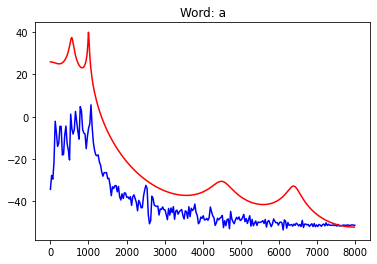

The coefficients for  i of 10th order linear model are:  [-1.70101548  2.24695799 -2.16695916  1.89512219 -1.97050439  1.29626781
 -0.70528688  0.08345949  0.04318883  0.06961684]


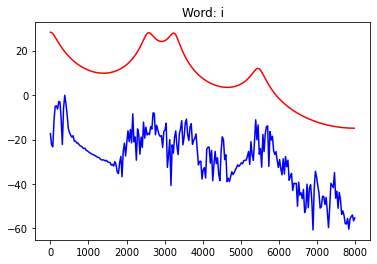

The coefficients for  u of 10th order linear model are:  [-3.94671971  6.80747724 -7.06661986  5.12559555 -2.96978685  2.08693358
 -1.83500734  0.99513368 -0.17982359 -0.01384936]


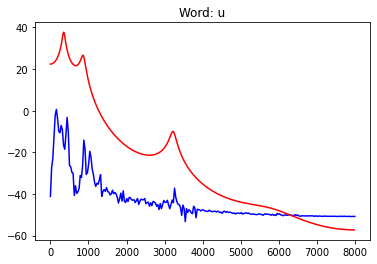

In [ ]:
#All imports
import numpy as np
import matplotlib.pyplot as plt
import pysptk #This module contains the functions to estimate the vocal tract parameters, excitation information etc
from scipy.signal import lfilter
from scipy.io import wavfile
import scipy
import scipy.signal as sig

Dict_vowel = ExtractVowel(Dict_male_recording, rate)
words = ["a","i","u"]
fftData = {}

for word in words:
  hamming_window = scipy.signal.hamming(len(Dict_male_vowel[word]))
  Dict_vowel[word] = Dict_vowel[word] * hamming_window
  fftData[word] = np.fft.fft(Dict_vowel[word],n=512)

# iy_data_hamming = Dict_vowel["a"]

# fft_iy_data_hamming = np.fft.fft(iy_data_hamming,n=512)
# N = int(len(fft_iy_data_hamming)/2)
# fft_x_axis = np.linspace(0,(16000/ 2),N)
# plt.title("Log-spectrum of /a/ with Hamming window")
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Amplitude")
# plt.plot(fft_x_axis,20*np.log10(np.abs(fft_iy_data_hamming[:N])))
# plt.show()

################################################################################
#Estimate the vocal tract parameters & Plot the vocal tract responce from the estimated vocal tract parameters
################################################################################
#You can estimate the vocal tract parameters (a_k) with autocorrelation matrix. 
#You can also use pysptk.lpc module to estimate vocal tract parameters (a_k). This module explores the properties of autocorrelation matrix to efficiently estimate a_k's
#You can scipy.signal.freqz with appropriate arguments to plot the vocal tract responce

ar = {}
response = {}

for word in words:
  ar_s = pysptk.sptk.lpc(Dict_vowel[word],order=10)
  ar[word] = ar_s
  print("The coefficients for ",word,"of 10th order linear model are: ",ar_s[1:])
  w,h= sig.freqz(b=ar_s[0],a=(np.concatenate((np.array([1]),ar_s[1:]))),fs=16000)
  response[word] = [w, h]
  N = int(len(fftData[word])/2)
  fft_x_axis = np.linspace(0,(16000/ 2),N)
  # Plotting the log spectrum of the estimated frequency responses
  title_string = "Word: " + word
  plt.title(title_string)
  plt.plot(fft_x_axis,20*np.log10(np.abs(fftData[word][:N])),"b")
  plt.plot(w,20*np.log10(np.abs(h)),"r")
  plt.show() 

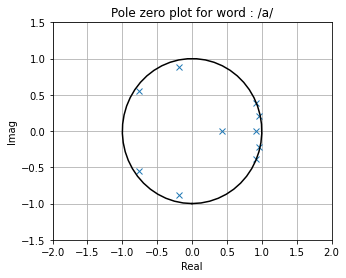

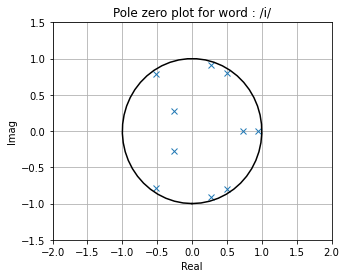

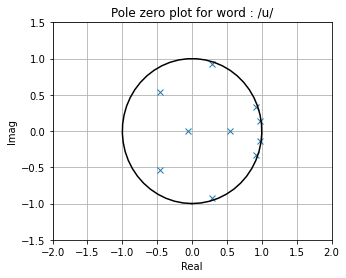

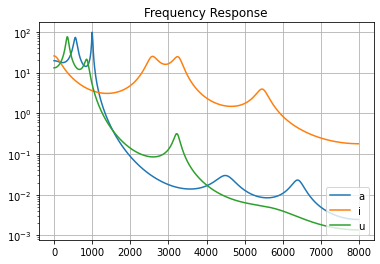

In [ ]:
################################################################################
#Estimate the location of poles in z-plane and thereby estimate the formant frequencies
################################################################################
#You can explore np.roots() function to acheive this,

def PoleZeroPlot(b, a, word):
    (zeros,poles,gain) = sig.tf2zpk(b, a)
    angle = np.linspace(-np.pi,np.pi,50)
    cirx = np.sin(angle)
    ciry = np.cos(angle)
    plt.figure()
    plt.plot(poles.real, poles.imag, 'x', zeros.real, zeros.imag, 'o', cirx,ciry, 'k-')
    plt.grid()
    
    plt.xlim((-2, 2))
    plt.xlabel('Real')
    plt.ylim((-1.5, 1.5))
    plt.ylabel('Imag')
    plt.gcf().set_figwidth(5)
    plt.title("Pole zero plot for word : /" + word + "/")
    return (zeros,poles,gain)

words = ["a","i","u"]

for word in words:
  b = [1]
  a = np.concatenate((np.array([1]),ar[word][1:]))
  PoleZeroPlot(b, a, word)
  plt.show()

for word in words:
  frq, resp = response[word]
  plt.semilogy(frq, np.abs(resp))
  plt.title('Frequency Response')
  plt.grid()

plt.legend(["a", "i", "u"], loc ="lower right")
plt.show()

# # Phase response
# for word in words:
#   frq, resp = response[word]
#   plt.plot(frq, np.angle(resp))
#   plt.title('Phase Response')
#   plt.grid()

# plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
/usr/local/lib/python3.7/dist-packages/scipy/signal/waveforms.py:658: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif idx == 'mid':
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


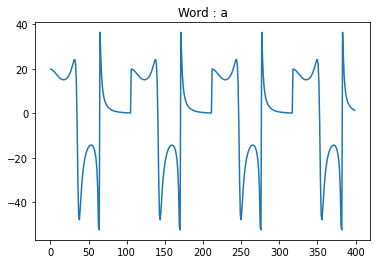

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


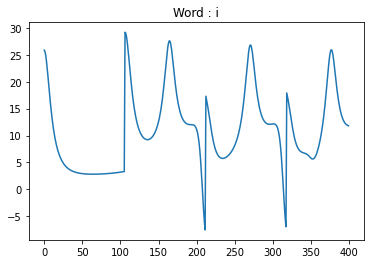

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


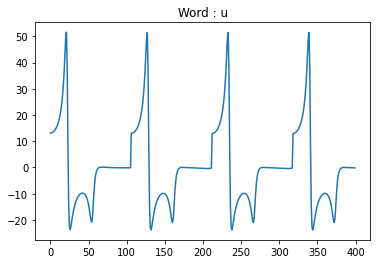

In [ ]:
################################################################################
#Estimate the excitation information i.e Pass the speech signal through inverse filter 
################################################################################
#You can use scipy.signal.lfilter function with appropriate arguments to estimate the excitation information 

excitation = {}

for word in words:
  b = [1]
  a = np.concatenate((np.array([1]),ar[word][1:]))
  y = sig.filtfilt(a, b, sustained[word])
  excitation[word] = y

################################################################################
#Synthesize the speech signal using estimated vocal tract parameters with different excitation signals i.e periodic impulses, random noise etc
################################################################################
#1. Syntesize the signal with both periodic impulses ( synthesize different speech signals with different periods ) and random noise 

genSignals = {}
t = 3
rate = 16000
F0 = 150
excitations = np.arange(0,rate*3-1,int(rate/F0), dtype=np.integer)
imp = sig.unit_impulse(rate*3, excitations)

for word in words:
  b = [1]
  a = np.concatenate((np.array([1]),ar[word][1:]))
  h = response[word][1]
  # y = scipy.signal.filtfilt(b, a, imp)
  y = np.convolve(imp, h, mode="full")
  plt.plot(y[0:400])
  plt.title("Word : " + word)
  plt.show()

################################################################################
#Listen to both synthesized and original speech signal and write your observations in the report
################################################################################








<h4> <b> Part3 report : </b>  
Write down your observations in part3 of this programming assignment  </h4> 

<dt> <h4> 1. What did you observe from the linear prediction spectrum of the vowels ?   </h4> </dt>
<dd> <h4> -  Does it have pitch harmonics ? </h4> </dd> 
From the frequency response plots we can infer that formants for /a/ are first formant : 600 H, second formant : 1100Hz and for /i/ are first formant : 100H, second formant : 2500Hz , and for /u/ are first formant : 300H, second formant : 900Hz

It doesn't have any pitch harmonics information as excitation information is removed.
<dt> <h4> 2. Write down your observations from the synthesized vowels  </h4> </dt>
<dd> <h4> - What happens if you change the time period of the excitation (periodic impulse) during the synthesis of the vowels ? </h4> With different time periods, we can synthesize signals with different pitch frequencies. We just have to change the frequencies of impulse signals to get this effect.</dd>  
<dd> <h4> - What happens if you use the random noise as excitation during the synthesis of the vowels ? </h4> We cannot generate voiced signals with random noise as excitation, because for voiced signals we need periodic excitation. Random noise based excitation is only for consonants production.</dd>

<h4> <b> Speech Recording </b> </h4>

This section provides the modules to record the speech signal in an online mode.


In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

<h4> <b> Module for recording the speech signal </b> </h4>

1. The below code records the speech signal for 3 sec ( you can change the duration of the recording in the code ) and store it as 'recording.wav' <br/>

2. If you have already recorded or uploaded the file named 'recording.wav', the code uses that file. Otherwise, it records and saves the file with the name 'recording.wav.' 

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io.wavfile
import io
import os

#### Please comment below line, if you already uploaded the 'recording.wav' in '/content/'
!rm recording.wav

if os.path.isfile('recording_a.wav') or os.path.isfile('recording_i.wav') or os.path.isfile('recording_u.wav'):
    print("wavefile exists, later part of the code uses 'recording_a,e,u.wav' as input speech")
else:
    print("There are no recordings ( recording_a.wav, recording_i.wav and recording_u.wav ) in the current directory, please record your voice")
    print("Recording vowel /a/ in hot")
    wav = record(3.0) #It will record three seconds of your speech ( For single vowels recording you can decrease the length )
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording_a.wav', 16000, fp_arr)
    print("Recording vowel /i/ in heat")
    wav = record(3.0) #It will record three seconds of your speech
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording_i.wav', 16000, fp_arr)
    print("Recording vowel /u/ in hoot")
    wav = record(3.0) #It will record three seconds of your speech
    wav = wav.set_frame_rate(16000)
    sig=wav.get_array_of_samples()
    samples=np.array(sig).T.astype(np.float32)
    fp_arr = np.array(samples).T.astype(np.float32)
    fp_arr /= np.iinfo(sig.typecode).max
    scipy.io.wavfile.write('recording_u.wav', 16000, fp_arr)



